# Exploring Damage Creation
##### Revising damage-generating functions to produce tuple: damaged image and its mask

In [6]:
# !pip install opencv-contrib-python

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage.exposure
from numpy.random import default_rng
import os
import random
from PIL import Image, ImageDraw, ImageFilter
import albumentations as A

In [23]:
os.getcwd()

'/mnt/processed/private/msds2025/cpt2/ML 3/Final Project/damage_generation'

In [27]:
import os
import random

import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFilter

import albumentations as A

class ScratchDamage:
    """
    Simulates dashed, weathered scratch lines with subtle grayscale variation.
    Each scratch is made of short segments with gaps in between.
    """

    def __init__(
        self,
        num_scratches_range=(100, 200),
        segment_range=(4, 8),
        segment_length_range=(5, 15),
        gap_length_range=(3, 6),
        angle_range=(-0.2, 0.2),
        thickness=1,
        color_cycle=None
    ):
        self.num_scratches_range = num_scratches_range
        self.segment_range = segment_range
        self.segment_length_range = segment_length_range
        self.gap_length_range = gap_length_range
        self.angle_range = angle_range
        self.thickness = thickness
        self.color_cycle = color_cycle or [
            (30, 30, 30),
            (100, 100, 100),
            (180, 180, 180),
            (240, 240, 240)
        ]

    def apply(self, image_pil):
        if image_pil.mode != 'RGBA':
            image_pil = image_pil.convert('RGBA')

        width, height = image_pil.size
        overlay = Image.new('RGBA', (width, height), (0, 0, 0, 0))
        draw = ImageDraw.Draw(overlay)

        # Create black image for the mask (binary: 0 for background, 255 for damage)
        mask_pil = Image.new('L', (width, height), 0)
        draw_mask = ImageDraw.Draw(mask_pil)

        num_scratches = random.randint(*self.num_scratches_range)

        for _ in range(num_scratches):
            x = random.randint(0, width)
            y = random.randint(0, height)
            angle = random.uniform(*self.angle_range)
            num_segments = random.randint(*self.segment_range)

            for seg in range(num_segments):
                seg_len = random.randint(*self.segment_length_range)
                gap_len = random.randint(*self.gap_length_range)

                dx = int(seg_len * np.sin(angle))
                dy = int(seg_len * np.cos(angle))

                x_end = np.clip(x + dx, 0, width - 1)
                y_end = np.clip(y + dy, 0, height - 1)

                color = self.color_cycle[seg % len(self.color_cycle)] + (random.randint(100, 180),)
                draw.line([(x, y), (x_end, y_end)], fill=color, width=self.thickness)

                # Draw same line on mask
                draw_mask.line([(x, y), (x_end, y_end)], fill=255, width=self.thickness)

                # Move to end of gap
                x = np.clip(x_end + int(gap_len * np.sin(angle)), 0, width - 1)
                y = np.clip(y_end + int(gap_len * np.cos(angle)), 0, height - 1)

                if y >= height:
                    break

        return Image.alpha_composite(image_pil, overlay).convert('RGB'), mask_pil


class WaterDiscolouration:
    """
    Simulates water stain effects by overlaying irregular semi-transparent
    brownish blobs on the image. Blur is applied for realism.
    """

    def __init__(
        self,
        num_stains_range=(1, 5),
        stain_size_factor_range=(0.1, 0.4),
        alpha_range=(50, 150),
        color_tint=(200, 180, 150)
    ):
        self.num_stains_range = num_stains_range
        self.stain_size_factor_range = stain_size_factor_range
        self.alpha_range = alpha_range
        self.color_tint = color_tint

    def apply(self, image_pil):
        """
        Apply semi-transparent brownish stains, blurred for realism.
        Returns a stained version of the original image.
        """
        # Create a transparent overlay for stains
        overlay = Image.new('RGBA', image_pil.size, (0, 0, 0, 0))
        draw = ImageDraw.Draw(overlay)
        width, height = image_pil.size
        num_stains = random.randint(*self.num_stains_range)

        # Create black image for the mask (binary: 0 for background, 255 for damage)
        mask_pil = Image.new('L', (width, height), 0)
        draw_mask = ImageDraw.Draw(mask_pil)

        for _ in range(num_stains):
            # Random stain radius
            rw = (
                random.uniform(*self.stain_size_factor_range) * width / 2
            )
            rh = (
                random.uniform(*self.stain_size_factor_range) * height / 2
            )
            cx, cy = random.randint(0, width), random.randint(0, height)
            bbox = [cx - rw, cy - rh, cx + rw, cy + rh]

            # Semi-transparent brownish color
            alpha = random.randint(*self.alpha_range)
            stain_color = (*self.color_tint, alpha)

            draw.ellipse(bbox, fill=stain_color)

            # Draw same ellipse on mask
            draw_mask.ellipse(bbox, fill=255)

        # Blur to blend stains smoothly
        overlay = overlay.filter(
            ImageFilter.GaussianBlur(radius=random.uniform(5, 15))
        )

        if image_pil.mode != 'RGBA':
            image_pil = image_pil.convert('RGBA')

        return Image.alpha_composite(image_pil, overlay).convert('RGB'), mask_pil

class CraquelureDamage:
    """
    Simulates craquelure (fine cracking) by blending augmented crack masks
    with random earthy tint and variable opacity over the painting.
    """

    def __init__(
        self,
        crack_mask_dir="../data/crack-masks",
        alpha_range=(0.5, 0.9),
        color_options=None
    ):
        self.crack_mask_dir = crack_mask_dir
        self.alpha_range = alpha_range
        self.color_options = color_options or [
            [0.2, 0.18, 0.15],  # dark brown
            [0.25, 0.23, 0.2],  # medium brown
            [0.3, 0.3, 0.3],    # grayish
            [0.28, 0.27, 0.2],  # olive
            [0.35, 0.3, 0.25]   # warm ochre
        ]

        self.crack_mask_paths = [
            os.path.join(self.crack_mask_dir, fname)
            for fname in os.listdir(self.crack_mask_dir)
        ]

    def apply(self, image_pil):
        """
        Apply craquelure damage using a randomly selected and augmented crack mask.
        Returns a PIL image with crack effects blended in.
        """
        crack_path = random.choice(self.crack_mask_paths)
        crack_mask = Image.open(crack_path).convert("L").resize(image_pil.size)
        
        img_np = np.array(image_pil).astype(np.float32) / 255.0
        mask_np = np.array(crack_mask).astype(np.uint8)
        
        mask_aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5)
        ])
        augmented = mask_aug(image=mask_np)
        aug_mask = augmented["image"]
        
        # Ensure binary (0 or 255)
        _, binary_aug_mask = cv2.threshold(aug_mask, 127, 255, cv2.THRESH_BINARY)
        
        # Convert mask to 3-channel for overlay computation (but keep single-channel binary for output mask)
        aug_mask_3c = np.stack([binary_aug_mask / 255] * 3, axis=-1)
        
        base_tint = np.array(random.choice(self.color_options))
        dark_crack = np.ones_like(img_np) * base_tint
        alpha = random.uniform(*self.alpha_range)
        
        craquelured_np = (
            img_np * (1 - alpha * aug_mask_3c) +
            dark_crack * (alpha * aug_mask_3c)
        )
        craquelured_img = Image.fromarray((craquelured_np * 255).astype(np.uint8))
        
        # Convert single-channel binary mask back to PIL Image
        mask_pil = Image.fromarray(binary_aug_mask)
        
        return craquelured_img, mask_pil

In [19]:
os.getcwd()

'/mnt/processed/private/msds2025/cpt2/ML 3/Final Project/damage_generation'

Creating dummy crack mask directory: /mnt/processed/private/msds2025/cpt2/ML 3/Final Project/damage_generation/data/crack-masks
ERROR: Sample image not found at /mnt/processed/private/msds2025/cpt2/ML 3/Final Project/damage_generation/data/img/full/dc9cb25d149c561755331ad627c44d1c5bbb0c09.jpg
Creating a dummy image for demonstration.

--- Testing ScratchDamage ---


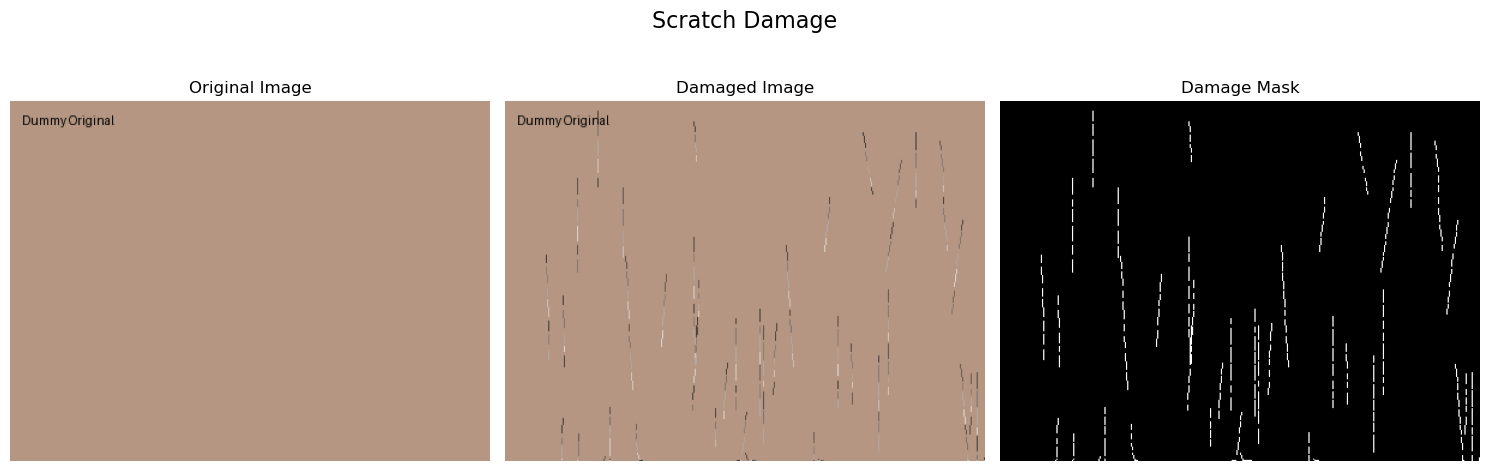


--- Testing WaterDiscolouration ---


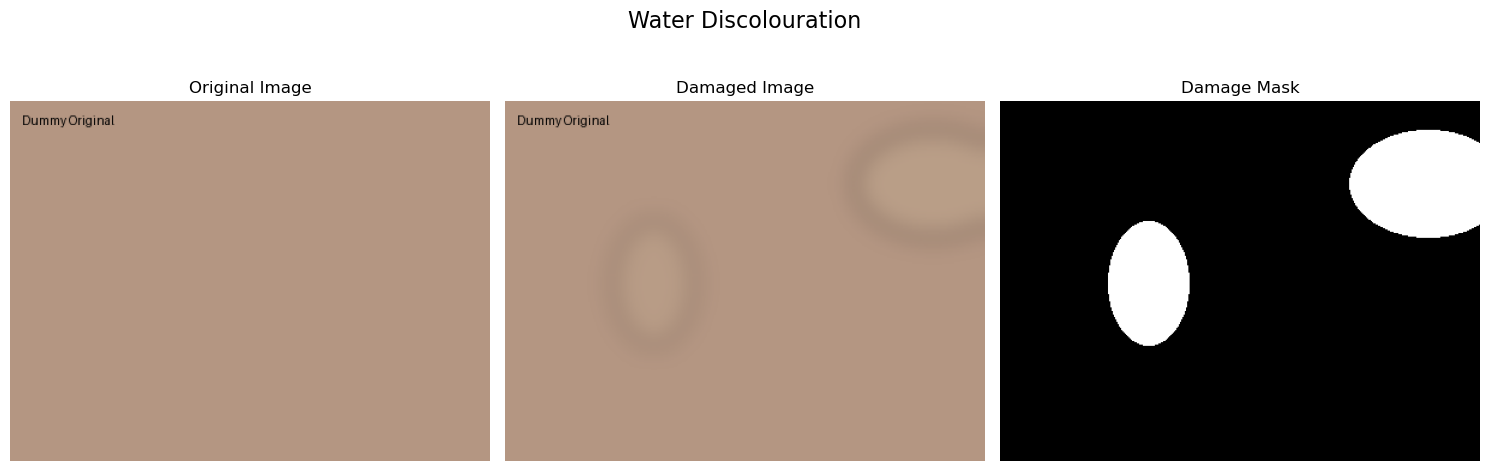

In [21]:
# Define paths based on your structure
# Current script directory: /mnt/processed/private/msds2025/cpt2/ML 3/Final Project/damage_generation/
# Image directory: /mnt/processed/private/msds2025/cpt2/ML 3/Final Project/data/img/full/

# Assuming this script is run from '.../damage_generation/'
project_root = os.path.abspath(os.path.join(os.getcwd(), "."))
image_dir = os.path.join(project_root, "data", "img", "full")
sample_image_filename = "dc9cb25d149c561755331ad627c44d1c5bbb0c09.jpg"
full_sample_image_path = os.path.join(image_dir, sample_image_filename)

# Path for Craquelure masks (relative to project_root or absolute)
# Example: if 'data/crack-masks' is inside 'Final Project'
craquelure_mask_directory = os.path.join(project_root, "data", "crack-masks")
# --- IMPORTANT: Create this directory and add some PNG/JPG crack masks to it ---
# For demonstration, we'll check if it exists and create a dummy mask if not.
if not os.path.exists(craquelure_mask_directory):
    print(f"Creating dummy crack mask directory: {craquelure_mask_directory}")
    os.makedirs(craquelure_mask_directory, exist_ok=True)
    dummy_crack_mask = Image.new('L', (100,100), 0)
    ImageDraw.Draw(dummy_crack_mask).line([(10,10), (90,90)], fill=255, width=2)
    dummy_crack_mask.save(os.path.join(craquelure_mask_directory, "dummy_crack1.png"))


# Load the sample image
try:
    original_pil_img = Image.open(full_sample_image_path)
    print(f"Successfully loaded original image: {full_sample_image_path}")
except FileNotFoundError:
    print(f"ERROR: Sample image not found at {full_sample_image_path}")
    print("Creating a dummy image for demonstration.")
    original_pil_img = Image.new('RGB', (400, 300), color=(180, 150, 130))
    ImageDraw.Draw(original_pil_img).text((10,10), "Dummy Original", fill=(0,0,0))
except Exception as e:
    print(f"Error loading image: {e}. Using a dummy image.")
    original_pil_img = Image.new('RGB', (400, 300), color=(180, 150, 130))
    ImageDraw.Draw(original_pil_img).text((10,10), "Dummy Original (Error)", fill=(0,0,0))


# --- Test ScratchDamage ---
print("\n--- Testing ScratchDamage ---")
scratch_damager = ScratchDamage(num_scratches_range=(30, 60), thickness=1)
damaged_scratch_img, scratch_mask_img = scratch_damager.apply(original_pil_img.copy())
display_damage_application(original_pil_img, damaged_scratch_img, scratch_mask_img, "Scratch Damage")

# --- Test WaterDiscolouration ---
print("\n--- Testing WaterDiscolouration ---")
water_damager = WaterDiscolouration(num_stains_range=(2,4), alpha_range=(40,100))
damaged_water_img, water_mask_img = water_damager.apply(original_pil_img.copy())
display_damage_application(original_pil_img, damaged_water_img, water_mask_img, "Water Discolouration")



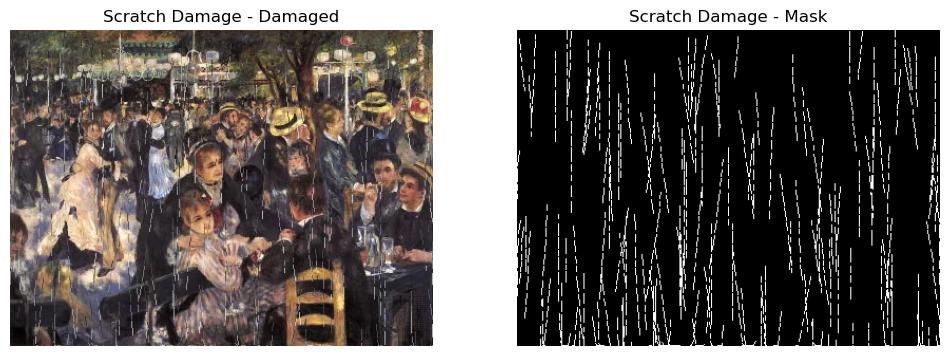

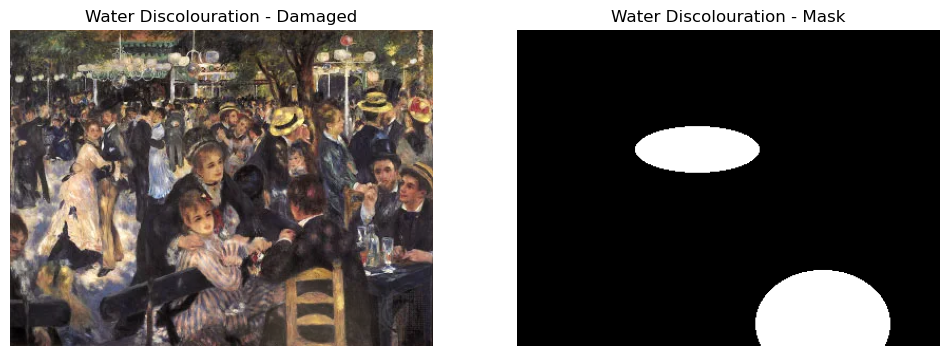

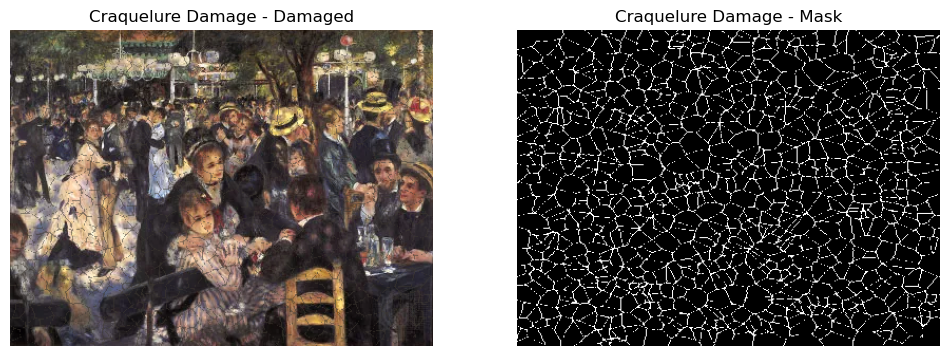

In [31]:
import os
from PIL import Image
import matplotlib.pyplot as plt
# from damage_effects import ScratchDamage, WaterDiscolouration, CraquelureDamage

base_dir = '/mnt/processed/private/msds2025/cpt2/ML 3/Final Project'
image_path = os.path.join(base_dir, 'art-restoration-ai/data/sample-image-canvas-oil-Le-Moulin-de-la-Galette-1876.png')
crack_mask_dir = os.path.join(base_dir, 'art-restoration-ai/data/crack-masks')

# Load image
original_image = Image.open(image_path)

# Function to display images
def display_image(image, mask, title):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].set_title(f'{title} - Damaged')
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title(f'{title} - Mask')
    ax[1].axis('off')
    plt.show()

scratch_damage = ScratchDamage()
water_discolouration = WaterDiscolouration()
craquelure_damage = CraquelureDamage(crack_mask_dir=crack_mask_dir)

scratched_img, scratched_mask = scratch_damage.apply(original_image)
display_image(scratched_img, scratched_mask, 'Scratch Damage')

water_img, water_mask = water_discolouration.apply(original_image)
display_image(water_img, water_mask, 'Water Discolouration')

craquelure_img, craquelure_mask = craquelure_damage.apply(original_image)
display_image(craquelure_img, craquelure_mask, 'Craquelure Damage')